In [4]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

In [5]:
training_folder = '../../datasets/data21k_kaggle/train_images/'

In [6]:
samples_df = pd.read_csv("../../datasets/data21k_kaggle/train.csv")
samples_df = shuffle(samples_df, random_state=42)
samples_df["filepath"] = training_folder+samples_df["image_id"]
samples_df.head()

,image_id,label,filepath
9134,2615227158.jpg,4,../../datasets/data21k_kaggle/train_images/261...
1580,1277648239.jpg,3,../../datasets/data21k_kaggle/train_images/127...
7304,2305895487.jpg,3,../../datasets/data21k_kaggle/train_images/230...
13196,336299725.jpg,2,../../datasets/data21k_kaggle/train_images/336...
5333,1951270318.jpg,2,../../datasets/data21k_kaggle/train_images/195...


In [7]:
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

In [8]:
batch_size = 8
image_size = 512
input_shape = (image_size, image_size, 3)
dropout_rate = 0.4
classes_to_predict = sorted(training_df.label.unique())

In [9]:
training_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values, training_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

In [10]:
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

In [11]:
training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [12]:
adapt_data = tf.data.Dataset.from_tensor_slices(training_df.filepath.values)
def adapt_mode(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

adapt_data = adapt_data.map(adapt_mode, num_parallel_calls=AUTOTUNE)
adapt_data_batches = adapt_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=image_size, width=image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

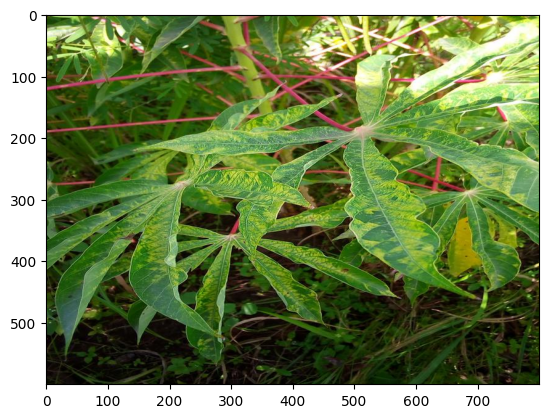

In [14]:
image = Image.open("../../datasets/data21k_kaggle/train_images/3412658650.jpg")
plt.imshow(image)
plt.show()

In [15]:
image = tf.expand_dims(np.array(image), 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10989722..254.64294].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6.7708673..221.31859].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6.5573635..232.48567].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..242.33252].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..246.4215].


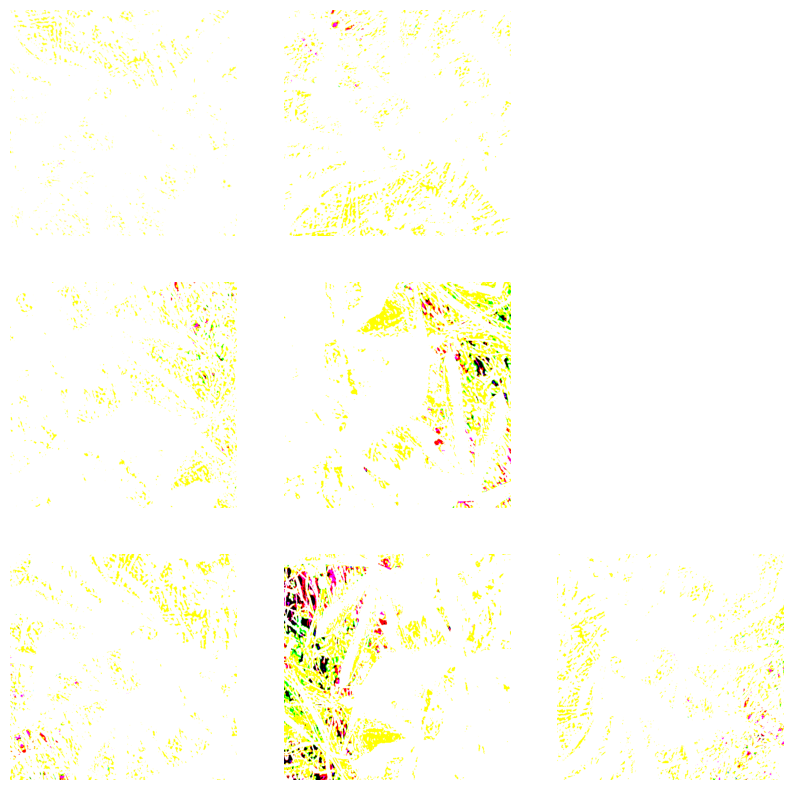

In [16]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation_layers(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [18]:
efficientnet = EfficientNetB3(weights="imagenet", 
                              include_top=False, 
                              input_shape=input_shape, 
                              drop_connect_rate=dropout_rate)

inputs = Input(shape=input_shape)
augmented = data_augmentation_layers(inputs)
efficientnet = efficientnet(augmented)
pooling = layers.GlobalAveragePooling2D()(efficientnet)
dropout = layers.Dropout(dropout_rate)(pooling)
outputs = Dense(len(classes_to_predict), activation="softmax")(dropout)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

43941136/43941136 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 16, 16, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685   

In [19]:
%%time
model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_data_batches)

CPU times: total: 9min 26s
Wall time: 1min 18s


In [20]:
epochs = 8
decay_steps = int(round(len(training_df)/batch_size))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

In [21]:
history = model.fit(
   training_data_batches,
   epochs = epochs, 
   validation_data=validation_data_batches,
   callbacks=callbacks
)

Epoch 1/8


UnknownError: Graph execution error:

Detected at node 'model/sequential/random_crop/loop_body/cond/crop_to_bounding_box/Slice/pfor/mod' defined at (most recent call last):
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nicho\AppData\Local\Temp\ipykernel_18456\443160415.py", line 1, in <module>
      history = model.fit(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 563, in call
      return super().call(inputs, training)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 441, in call
      self._batch_augment(inputs), is_dict, use_targets
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 472, in _batch_augment
      return self._map_fn(self._augment, inputs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\tensorflow\python\ops\parallel_for\pfor.py", line 4472, in f
      [converter._convert_helper(x).t for x in func._func_graph_outputs])
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\tensorflow\python\ops\parallel_for\pfor.py", line 4472, in f
      [converter._convert_helper(x).t for x in func._func_graph_outputs])
Node: 'model/sequential/random_crop/loop_body/cond/crop_to_bounding_box/Slice/pfor/mod'
Detected at node 'model/sequential/random_crop/loop_body/cond/crop_to_bounding_box/Slice/pfor/mod' defined at (most recent call last):
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nicho\AppData\Local\Temp\ipykernel_18456\443160415.py", line 1, in <module>
      history = model.fit(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 563, in call
      return super().call(inputs, training)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 441, in call
      self._batch_augment(inputs), is_dict, use_targets
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 472, in _batch_augment
      return self._map_fn(self._augment, inputs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\tensorflow\python\ops\parallel_for\pfor.py", line 4472, in f
      [converter._convert_helper(x).t for x in func._func_graph_outputs])
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\tensorflow\python\ops\parallel_for\pfor.py", line 4472, in f
      [converter._convert_helper(x).t for x in func._func_graph_outputs])
Node: 'model/sequential/random_crop/loop_body/cond/crop_to_bounding_box/Slice/pfor/mod'
2 root error(s) found.
  (0) UNKNOWN:  JIT compilation failed.
	 [[{{node model/sequential/random_crop/loop_body/cond/crop_to_bounding_box/Slice/pfor/mod}}]]
	 [[Func/model/sequential/random_zoom/loop_body/stateful_uniform/Bitcast_1/pfor/while/body/_518/input/_1309/_386]]
  (1) UNKNOWN:  JIT compilation failed.
	 [[{{node model/sequential/random_crop/loop_body/cond/crop_to_bounding_box/Slice/pfor/mod}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_74098]

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
model.load_weights("best_model.h5")